# 5. Generative adversarial networks

- Used as part of INFO8010 Deep Learning (Gilles Louppe, 2018-2019).
- Originally adapted from [Pytorch tutorial for Deep Learning researchers](https://github.com/yunjey/pytorch-tutorial) (Yunvey Choi, 2018).

---

In [0]:
import os
import torch
import torchvision
import torch.nn as nn
#import tensorboardX
from torchvision import transforms
from torchvision.utils import save_image

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
!pip install tensorboardX

# Hyper-parameters

The hyperparameters that are needed for successfully training your first GAN

In [0]:
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 30
batch_size = 100
sample_dir = 'samples'

# Data

We define a data generator as usual which will normalize the input data before feeding it to the model. 

In [0]:
# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Image processing
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],   # 3 for RGB channels
                                     std=[0.5])])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='./data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

<div class="alert alert-success">
<b>EXERCISE</b>:

Define the Discriminator and Generator neural architectures.
Remember that these are the building blocks of any neural architecture, so you should consider:
<ul>
    <li>The amount of hidden layers and units </li>
    <li>Non-linearities between layers</li>
    <li>Final activation function (should be tanh for the generator)</li>
</ul>
   
Pay special attention to the last activation function of your models.
</div>

In [0]:
# Discriminator
D = nn.Sequential(
    nn.Linear(image_size,512),
    nn.LeakyReLU(),
    nn.Linear(512,256),
    nn.LeakyReLU(),
    nn.Linear(256,hidden_size),
    nn.LeakyReLU(),
    nn.Linear(hidden_size,1),
    nn.Sigmoid())
# Generator (ending )
G = nn.Sequential(
    nn.Linear(latent_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,256),
    nn.ReLU(),
    nn.Linear(256,512),
    nn.ReLU(),
    nn.Linear(512,image_size),
    nn.Tanh())

In [0]:
# Device setting
D = D.to(device)
G = G.to(device)

<div class="alert alert-success">
<b>EXERCISE</b>:

Define the loss function you would like to minimize and two appropriate optimizers with reasonable learning rates.
Remember what has been discussed during the lecture.

</div>


In [0]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.SGD(D.parameters(), lr=0.001, momentum=0.9)
g_optimizer = torch.optim.SGD(G.parameters(), lr=0.001, momentum=0.9)

# Utils

Here are some auxiliary functions which will make your training easier.
<ul>
    <li>The first function transforms the output of your generator into a meaningful image.</li>
    <li>The second function will avoid the accumulation of the gradients during training: you will have to call this function yourself!</li>
</ul>


In [0]:
# Utils
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

<div class="alert alert-success">
<b>EXERCISE</b>:


Here are the steps you need to define if you want a proper training loop:

<ul>
    <li>Start by defining the labels that are used at training time </li>
    <li>Evaluate the performance of the discriminator based on the different inputs that it requires:
    <ul>
        <li> Remember that it has access to two things, therefore be sure to use them both and to compute its final loss accordingly </li>
    </ul>
    </li>
   <li> Make a proper use of the tensorboard methods that are being used, what do they expect as input? </li>
    <li> Be sure the make a good use of the utils </li>
    
</ul>

</div>

In [0]:
total_step = len(data_loader)

# Add appropriate labels
ten = torch.ones(batch_size,1).to(device)
fake_labels = torch.zeros(batch_size,1).to(device)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        ## Train your discriminator

        outputs = D(images)
        
        d_loss_real = criterion(outputs,ten)#firstly, we compare true (100%) and true of outputs(softmax)
        
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs,fake_labels)
        
        # Backprop and optimize the discriminator
        d_loss = d_loss_real+d_loss_fake
        reset_grad()
        d_loss.backward(retain_graph=True)
        d_optimizer.step()
        
        ## Train your generator
        
        outputs = D(fake_images)        
        g_loss = -criterion(outputs, fake_labels) #compare zeros
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward(retain_graph=True)
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item()))
    
    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
        
    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Epoch [0/30], Step [200/600], d_loss: 0.3778, g_loss: -0.3711
Epoch [0/30], Step [400/600], d_loss: 0.1601, g_loss: -0.1579
Epoch [0/30], Step [600/600], d_loss: 0.0760, g_loss: -0.0747
Epoch [1/30], Step [200/600], d_loss: 0.0419, g_loss: -0.0412
Epoch [1/30], Step [400/600], d_loss: 0.0262, g_loss: -0.0258
Epoch [1/30], Step [600/600], d_loss: 0.0181, g_loss: -0.0177
Epoch [2/30], Step [200/600], d_loss: 0.0132, g_loss: -0.0130
Epoch [2/30], Step [400/600], d_loss: 0.0102, g_loss: -0.0100
Epoch [2/30], Step [600/600], d_loss: 0.0081, g_loss: -0.0080
Epoch [3/30], Step [200/600], d_loss: 0.0067, g_loss: -0.0066
Epoch [3/30], Step [400/600], d_loss: 0.0057, g_loss: -0.0056
Epoch [3/30], Step [600/600], d_loss: 0.0048, g_loss: -0.0047
Epoch [4/30], Step [200/600], d_loss: 0.0042, g_loss: -0.0041
Epoch [4/30], Step [400/600], d_loss: 0.0037, g_loss: -0.0036
Epoch [4/30], Step [600/600], d_loss: 0.0034, g_loss: -0.0032
Epoch [5/30], Step [200/600], d_loss: 0.0029, g_loss: -0.0029
Epoch [5

KeyboardInterrupt: ignored

# When you think you are done ...

Training this model on your own machine can be particularly expensive if you do not have a GPU.
Therefore you can try to run your notebook on [Google-Colab](https://colab.research.google.com/notebooks/welcome.ipynb).

<div class="alert alert-success">
<b>EXERCISE</b>:


Investigate what happens when using always the same set of images within a training batch.
Monitor the behaviour of the loss and the resulting generated samples in tensorboard.
Which phenomenon do you observe?

</div>

<div class="alert alert-success">
<b>EXERCISE</b>:
    
Now instead of using the MNIST dataset try to train a GAN on the images coming from the [Cifar-10]()
dataset. In this case you should define an architecture based on convolutional layers.

</div>

'\nimport numpy as np\nfrom PIL import Image\nfake_image = np.array(fake_image.tolist()).reshape(28,28)\nnew = Image.fromarray(fake_image)'

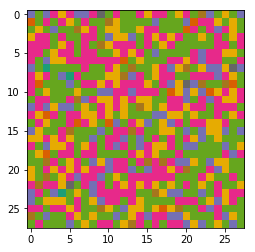

In [0]:
z = torch.randn(latent_size).to(device)
fake_image = G(z)
fake_image = denorm(fake_image)

from matplotlib import pyplot as plt
%matplotlib inline
fake_image = np.array(fake_image.tolist()).reshape(28, 28)
plt.imshow(fake_image,'Dark2')
"""
import numpy as np
from PIL import Image
fake_image = np.array(fake_image.tolist()).reshape(28,28)
new = Image.fromarray(fake_image)"""

